In [2]:
from PIL import ImageGrab
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output
from itertools import product

Safe move: (1, 8)


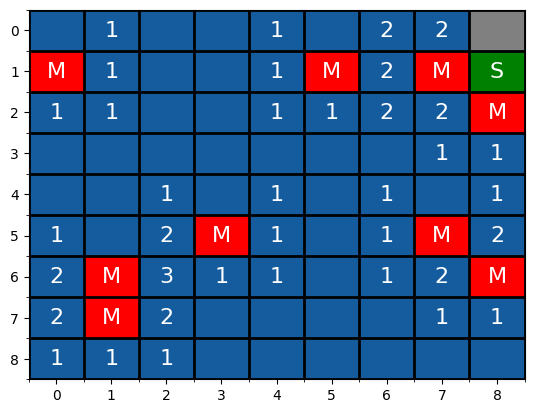

In [6]:
# Coordenadas de la cuadrícula en la pantalla (ajusta según sea necesario)
left, top, right, bottom = 195, 356, 575, 736

# Captura la parte de la pantalla donde está la cuadrícula del Buscaminas
screenshot = ImageGrab.grab(bbox=(left, top, right, bottom))

# Guarda la imagen capturada
screenshot.save("captura_color.png")

# Convierte la captura a un formato que OpenCV pueda procesar (array de numpy)
screenshot_np = np.array(screenshot)

# Convierte la imagen a escala de grises
gray_image = cv2.cvtColor(screenshot_np, cv2.COLOR_BGR2GRAY)

# Guarda la imagen en escala de grises
cv2.imwrite("captura_gris.png", gray_image)

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Definir el tamaño de la celda
cell_size = 42  # Cada celda es de 40x40 píxeles

# Crear una matriz vacía para almacenar los valores
board_matrix = np.zeros((9, 9), dtype=int)

# Iterar sobre cada celda en la imagen
for i in range(9):
    for j in range(9):
        # Recortar la celda correspondiente
        cell_img = gray_image[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
        
        # Calcular el promedio de los píxeles para determinar el color de la celda
        avg_pixel_value = np.mean(cell_img)
        
        if avg_pixel_value < 128:  # Si el valor promedio es bajo, la celda es gris
            board_matrix[i, j] = -1  # Inicialmente se asume que es una celda gris
        
        # Invertir la imagen (Tesseract funciona mejor con texto oscuro en fondo claro)
        cell_img_inverted = cv2.bitwise_not(cell_img)
        
        # Usar Tesseract para detectar números en la celda
        text = pytesseract.image_to_string(cell_img_inverted, config='--psm 10 digits')
        
        # Limpiar el texto detectado
        text = text.strip()
        
        # Asignar el valor detectado en la matriz si es un número válido
        if text.isdigit():
            board_matrix[i, j] = int(text)
        elif avg_pixel_value >= 128:  # Si la celda es blanca y no tiene número, la dejamos en 0
            board_matrix[i, j] = 0

class MinesweeperSolver:
    def __init__(self, board):
        self.board = np.array(board)
        self.rows, self.cols = self.board.shape
        self.mines = set()
        self.safe_cells = set()

    def is_valid(self, row, col):
        return 0 <= row < self.rows and 0 <= col < self.cols

    def get_neighbors(self, row, col):
        neighbors = []
        for dr, dc in product([-1, 0, 1], repeat=2):
            if dr == 0 and dc == 0:
                continue
            r, c = row + dr, col + dc
            if self.is_valid(r, c):
                neighbors.append((r, c))
        return neighbors

    def count_unknowns_and_mines(self, neighbors):
        unknowns = []
        mine_count = 0
        for r, c in neighbors:
            if (r, c) in self.mines:
                mine_count += 1
            elif self.board[r, c] == 0:
                unknowns.append((r, c))
        return unknowns, mine_count

    def is_configuration_valid(self, unknowns, mines, safe_cells):
        for r, c in unknowns:
            if (r, c) in mines and (r, c) in safe_cells:
                return False
        for r in range(self.rows):
            for c in range(self.cols):
                if self.board[r, c] > 0:
                    neighbors = self.get_neighbors(r, c)
                    current_mines = sum((nr, nc) in mines for nr, nc in neighbors)
                    if current_mines > self.board[r, c]:
                        return False
                    current_safe = sum((nr, nc) in safe_cells for nr, nc in neighbors)
                    if current_mines + current_safe > len(neighbors):
                        return False
        return True

    def backtrack(self, unknowns, current_index, mines, safe_cells):
        if current_index == len(unknowns):
            if self.is_configuration_valid(unknowns, mines, safe_cells):
                self.mines.update(mines)
                self.safe_cells.update(safe_cells)
                return True
            return False

        r, c = unknowns[current_index]

        # Intentar marcar la celda como mina
        mines.add((r, c))
        if self.backtrack(unknowns, current_index + 1, mines, safe_cells):
            return True
        mines.remove((r, c))

        # Intentar marcar la celda como segura
        safe_cells.add((r, c))
        if self.backtrack(unknowns, current_index + 1, mines, safe_cells):
            return True
        safe_cells.remove((r, c))

        return False

    def infer_mines_and_safe_cells(self):
        progress = True
        while progress:
            progress = False
            for row in range(self.rows):
                for col in range(self.cols):
                    if self.board[row, col] > 0:
                        neighbors = self.get_neighbors(row, col)
                        unknowns, mine_count = self.count_unknowns_and_mines(neighbors)

                        if len(unknowns) > 0 and len(unknowns) + mine_count == self.board[row, col]:
                            for cell in unknowns:
                                if cell not in self.mines:
                                    self.mines.add(cell)
                                    progress = True

                        elif len(unknowns) > 0 and mine_count == self.board[row, col]:
                            for cell in unknowns:
                                if cell not in self.safe_cells:
                                    self.safe_cells.add(cell)
                                    return cell  # Devuelve la primera celda segura encontrada

    def solve_for_one_safe_move(self):
        # Primero, intentamos inferir lo que se pueda de forma directa
        safe_move = self.infer_mines_and_safe_cells()

        # Si no se identificó ninguna celda segura en la inferencia, aplicamos backtracking
        if not safe_move:
            unknowns = [(r, c) for r in range(self.rows) for c in range(self.cols) if (r, c) not in self.mines and (r, c) not in self.safe_cells and self.board[r, c] == 0]
            if unknowns:
                self.backtrack(unknowns, 0, set(self.mines), set(self.safe_cells))
                if self.safe_cells:
                    safe_move = next(iter(self.safe_cells))

        if safe_move:
            print(f"Safe move: {safe_move}")
            return safe_move
        else:
            print("No safe move found.")
            return None

    def plot_board(self, safe_move=None):
        fig, ax = plt.subplots()
        ax.set_xticks(np.arange(self.cols + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(self.rows + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=2)

        for r in range(self.rows):
            for c in range(self.cols):
                if self.board[r, c] > 0:
                    ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, fill=True, color='#145c9e'))
                    ax.text(c, r, str(self.board[r, c]), va='center', ha='center', fontsize=16, color='white')
                elif self.board[r, c] == -1:
                    ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, fill=True, color='#145c9e'))
                else:
                    ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, fill=True, color='grey'))

        for (r, c) in self.mines:
            ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, fill=True, color='red'))
            ax.text(c, r, 'M', va='center', ha='center', fontsize=16, color='white')

        if safe_move:
            sr, sc = safe_move
            ax.add_patch(plt.Rectangle((sc - 0.5, sr - 0.5), 1, 1, fill=True, color='green'))
            ax.text(sc, sr, 'S', va='center', ha='center', fontsize=16, color='white')

        ax.set_xlim(-0.5, self.cols - 0.5)
        ax.set_ylim(-0.5, self.rows - 0.5)
        ax.invert_yaxis()
        plt.show()

solver = MinesweeperSolver(board_matrix)
safe_move = solver.solve_for_one_safe_move()
solver.plot_board(safe_move=safe_move)
